<a href="https://www.kaggle.com/code/subhadipde2000/instruction-tuning-gemma-3-with-lora?scriptVersionId=239466842" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Installing Required Libraries:

In [1]:
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.1/792.1 kB 22.2 MB/s eta 0:00:00


# Importing Required Libraries:

In [2]:
import os
import json
import keras
import random
import warnings
import keras_nlp
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

2025-05-13 12:20:01.945726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747138802.212566      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747138802.277625      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
warnings.filterwarnings("ignore")

# Setting Up the Keras Backend:

In [4]:
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1"
os.environ["JAX_PLATFORMS"] = ""

# Loading the Data:

In [5]:
data = []
category = []

with open('/kaggle/input/databricks-dolly-15k/databricks-dolly-15k.jsonl') as file:
    for line in file:
        record = json.loads(line)
        category.append(record['category'])

        # Filtering out examples with context, to keep it simple.
        if record["context"]:
            continue
            
        record_dict = {"prompts" : "", "responses" : ""}
        record_dict["prompts"] = record["instruction"]
        
        # if record["context"] != "":
            # record_dict["prompts"] += f" \n\nContext: {record['context']}"
            
        record_dict["responses"] = record["response"]
        
        data.append(record_dict)

In [6]:
# Taking only the first 2000 examples for faster training
data = data[:2000]

# Exploratory Data Analysis:

In [7]:
df = pd.DataFrame(
    {
        "Q&A Category" : category
    }
)

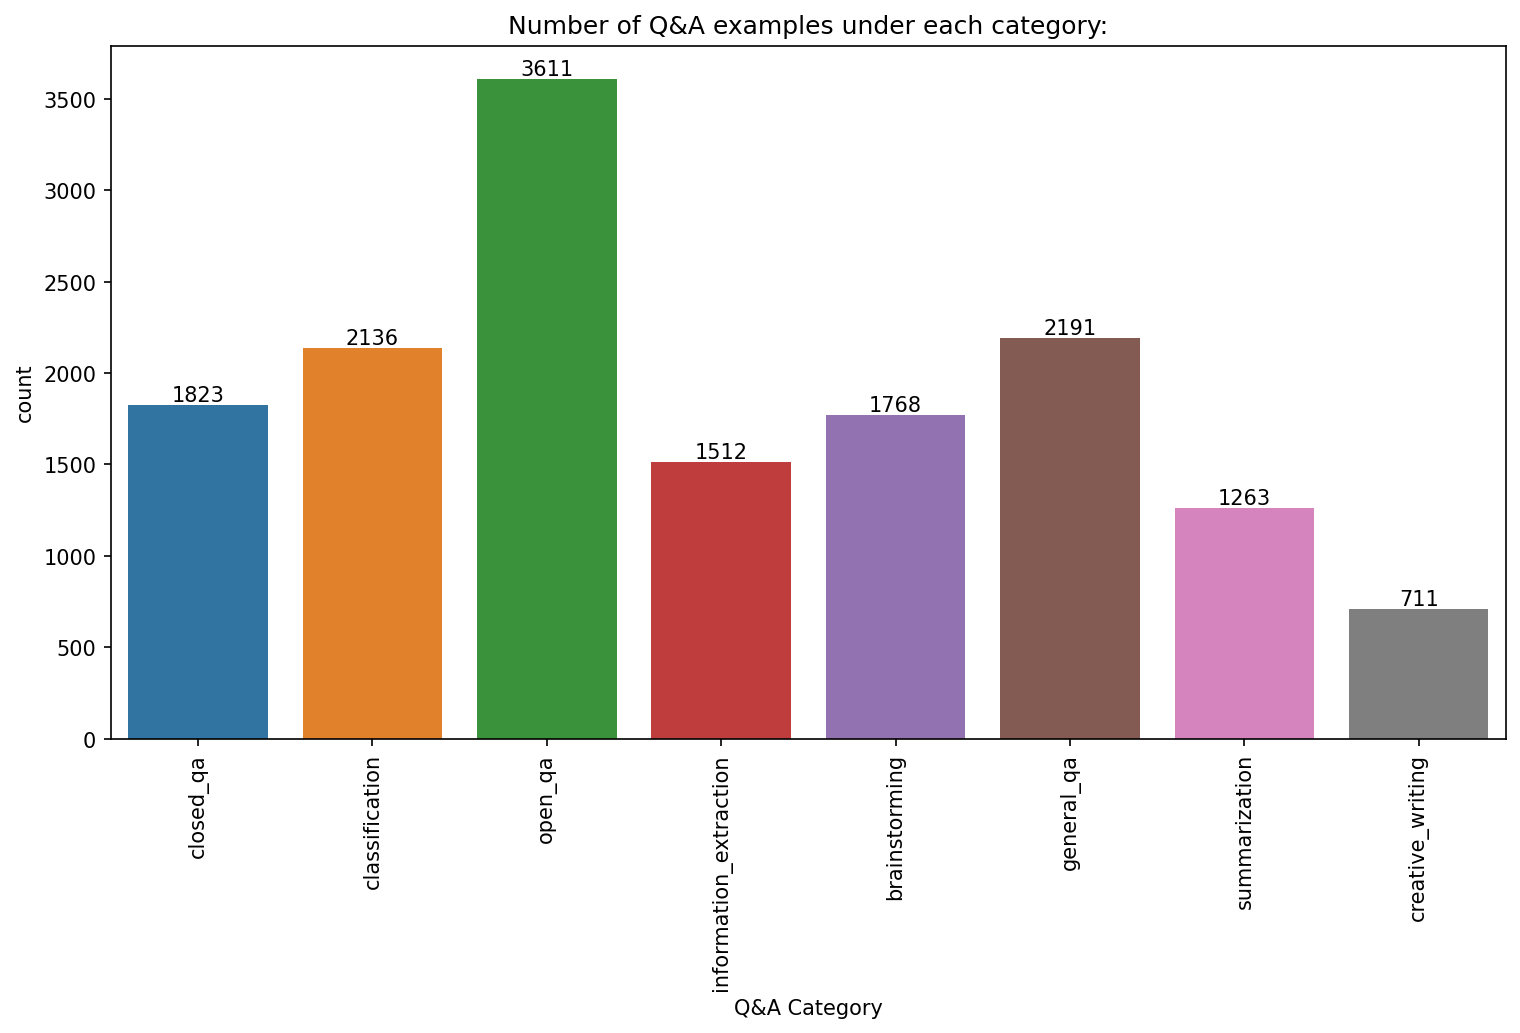

In [8]:
plt.figure(figsize=(12, 6), dpi=150)
plt.title("Number of Q&A examples under each category:")
plt.xticks(rotation=90)
ax = sns.countplot(data=df, x="Q&A Category")
ax.bar_label(ax.containers[0], fontsize=10);

# Function for Coloring and Formatting the Texts:

In [9]:
def colorize_text(text):
    for word, color in zip(["Instruction", "Context", "Response"], ["red", "blue", "green"]):
        text = text.replace(f"{word}:", f"**<font color='{color}' size='4'>{word}:</font>**")
    return text



def colorize_text_from_dict(text_dict):
    text = ""

    for key, value in text_dict.items():
        if key == "prompts":
            text += f"Instruction: {value}\n\n"
        elif key == "responses":
            text += f"Response: {value}\n\n"

    text = colorize_text(text)
    
    return text

In [10]:
# Visualizing a random text from the corpus
n = random.randint(0, len(data))
display(Markdown(colorize_text_from_dict(data[n])))

**<font color='red' size='4'>Instruction:</font>** Why are we like aquariums?

**<font color='green' size='4'>Response:</font>** Aquariums, like zoos, provide fun-filled leisure and entertainment activities that double-up as centres for animal rescue, care and rehabilitation, scientific research, education and conservation.



# Building TensorFlow Dataset:

In [11]:
def build_tf_dataset(text_dict_list):
    AUTO = tf.data.AUTOTUNE
    options = tf.data.Options()
    options.experimental_deterministic = False
    
    dataset = tf.data.Dataset.from_generator(
        lambda: (item for item in text_dict_list),
        output_signature={
            "prompts": tf.TensorSpec(shape=(), dtype=tf.string),
            "responses": tf.TensorSpec(shape=(), dtype=tf.string),
        }
    ).cache()

    dataset = dataset.shuffle(1024, seed=42)
    dataset = dataset.with_options(options).batch(1).prefetch(AUTO)

    return dataset

In [12]:
dataset = build_tf_dataset(data)

I0000 00:00:1747138819.595040      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# Loading the Gemma 3 Model with 1 Billion Parameters:

In [13]:
gemma3_1b = keras_nlp.models.Gemma3CausalLM.from_preset("gemma3_1b")
gemma3_1b.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)                            │                      Vocab size: 262,144 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma3_backbone               │ (None, None, 1152)        │     999,885,952 │ padding_mask[0][0],        │
│ (Gemma3Backbone)              │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 262144)      │     301,989,888 │ gemma3_backbone[0][0]      │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 999,885,952 (3.72 GB)

 Trainable params: 999,885,952 (3.72 GB)

 Non-trainable params: 0 (0.00 B)

# Inferenece Before Fine-tuning:

In [14]:
def generate_inference(prompt, max_length=256):
    colored_text = f"<center><font color='Yellow' size='6'>Gemma 3 Output:</font></center>\n\n"
    input_prompt = f"Instruction: \n{prompt} \n\nResponse:"
    response = gemma3_1b.generate(input_prompt, max_length=max_length)
    colored_text += f"{colorize_text(response)}"
    return colored_text

In [15]:
display(Markdown(generate_inference(prompt = "How to spend a nice sunny Sunday morning?")))

I0000 00:00:1747138861.821517      18 service.cc:148] XLA service 0x50bd4f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747138861.822497      18 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747138867.201168      18 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747138876.215324      18 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


<center><font color='Yellow' size='6'>Gemma 3 Output:</font></center>

**<font color='red' size='4'>Instruction:</font>** 
How to spend a nice sunny Sunday morning? 

**<font color='green' size='4'>Response:</font>** 
1.  Go to the beach. 
2.  Go to the park. 
3.  Go to the zoo. 
4.  Go to the mall. 
5.  Go to the library. 
6.  Go to the movies. 
7.  Go to the museum. 
8.  Go to the aquarium. 
9.  Go to the arcade. 
10.  Go to the bowling alley. 
11.  Go to the ice cream parlor. 
12.  Go to the ice skating rink. 
13.  Go to the trampoline park. 
14.  Go to the trampoline park. 
15.  Go to the trampoline park. 
16.  Go to the trampoline park. 
17.  Go to the trampoline park. 
18.  Go to the trampoline park. 
19.  Go to the trampoline park. 
20.  Go to the trampoline park. 
21.  Go to the trampoline park. 


In [16]:
display(Markdown(generate_inference(prompt = "Explain the transformer architecture in NLP in a way such that it's easy to understand.")))

<center><font color='Yellow' size='6'>Gemma 3 Output:</font></center>

**<font color='red' size='4'>Instruction:</font>** 
Explain the transformer architecture in NLP in a way such that it's easy to understand. 

**<font color='green' size='4'>Response:</font>** 
Transformer is a neural network architecture that has been widely used in natural language processing (NLP) for its ability to learn complex patterns from large amounts of text data. It consists of a series of layers that are stacked one on top of the other, with each layer progressively reducing the number of parameters and increasing the complexity of the network. The transformer architecture is inspired by the structure of the human brain, where the layers of neurons process information in parallel and are connected to each other through a series of gates. This architecture allows the network to learn complex patterns in the input data, such as word embeddings, and to generate coherent and fluent text outputs. The transformer architecture has been shown to be effective in a wide range of NLP tasks, including machine translation, text summarization, and question answering. It has also been shown to be able to learn complex patterns in the input data, such as word embeddings, and to generate coherent and fluent text outputs. The transformer architecture has been shown to be effective in a wide range of NLP tasks, including machine translation, text summarization, and question answering. It has also been shown to be able to learn

In [17]:
display(Markdown(generate_inference(prompt = "Explain the general theory of relativity to a 10 years old.", max_length=512)))

<center><font color='Yellow' size='6'>Gemma 3 Output:</font></center>

**<font color='red' size='4'>Instruction:</font>** 
Explain the general theory of relativity to a 10 years old. 

**<font color='green' size='4'>Response:</font>** 
The general theory of relativity is a theory that explains the motion of objects in the universe. It is based on the idea that gravity is a force that acts on all objects in the universe. The theory was developed by Albert Einstein in 1915. It is a very complex theory that involves many different concepts and ideas. 

The general theory of relativity is a very important theory because it explains how the universe works. It helps us understand how objects move in space and time. It also helps us understand how gravity affects objects. 

The general theory of relativity is a very difficult theory to understand. It is very complex and involves many different concepts and ideas. It is also very difficult to explain to someone who is not familiar with the theory. 

The general theory of relativity is a very important theory because it helps us understand how the universe works. It also helps us understand how gravity affects objects. It is a very important theory because it helps us understand how the universe works. 

The general theory of relativity is a very important theory because it explains how the universe works. It helps us understand how objects move in space and time. It also helps us understand how gravity affects objects. 

The general theory of relativity is a very important theory because it explains how the universe works. It helps us understand how objects move in space and time. It also helps us understand how gravity affects objects. 

The general theory of relativity is a very important theory because it explains how the universe works. It helps us understand how objects move in space and time. It also helps us understand how gravity affects objects. 

The general theory of relativity is a very important theory because it explains how the universe works. It helps us understand how objects move in space and time. It also helps us understand how gravity affects objects. 

The general theory of relativity is a very important theory because it explains how the universe works. It helps us understand how objects move in space and time. It also helps us understand how gravity affects objects. 

The general theory of relativity is a very important theory because it explains how the universe works. It helps us understand how objects move in space and time. It also helps us understand how gravity affects objects. 

The general theory of relativity is a very important theory because it explains how the universe works. It helps us understand how objects move in space and time. It also helps

# Fine-tuning with LoRA:

In [18]:
gemma3_1b.backbone.enable_lora(rank=4)
gemma3_1b.summary()

Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)                            │                      Vocab size: 262,144 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma3_backbone               │ (None, None, 1152)        │   1,000,538,240 │ padding_mask[0][0],        │
│ (Gemma3Backbone)              │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 262144)      │     301,989,888 │ gemma3_backbone[0][0]      │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,000,538,240 (3.73 GB)

 Trainable params: 652,288 (2.49 MB)

 Non-trainable params: 999,885,952 (3.72 GB)

In [19]:
gemma3_1b.preprocessor.sequence_length = 256

optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)

# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

In [20]:
gemma3_1b.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [21]:
history = gemma3_1b.fit(dataset, epochs=50)

Epoch 1/50


W0000 00:00:1747139002.322023      71 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 452s 178ms/step - loss: 0.6592 - sparse_categorical_accuracy: 0.5173
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 355s 177ms/step - loss: 0.6040 - sparse_categorical_accuracy: 0.5290
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 355s 177ms/step - loss: 0.6090 - sparse_categorical_accuracy: 0.5399
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 355s 177ms/step - loss: 0.5749 - sparse_categorical_accuracy: 0.5444
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 358s 179ms/step - loss: 0.5881 - sparse_categorical_accuracy: 0.5414
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 358s 179ms/step - loss: 0.5728 - sparse_categorical_accuracy: 0.5478
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 357s 179ms/step - loss: 0.5494 - sparse_categorical_accuracy: 0.5555
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 360s 180ms/step - loss: 0.5391 - sparse_categorical_accuracy: 0.5642
Epoch 9/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 359s 179ms/step - loss: 0.5256 - sparse_categorical_accuracy: 0.5686
Epoch 10/50


# Plotting Training Metric:

In [22]:
def plot_model_metric(metric):
    plt.figure(dpi=120)
    plt.plot(history.history[metric], label=metric)
    # plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.title(f'{metric} over Epochs')
    plt.show();

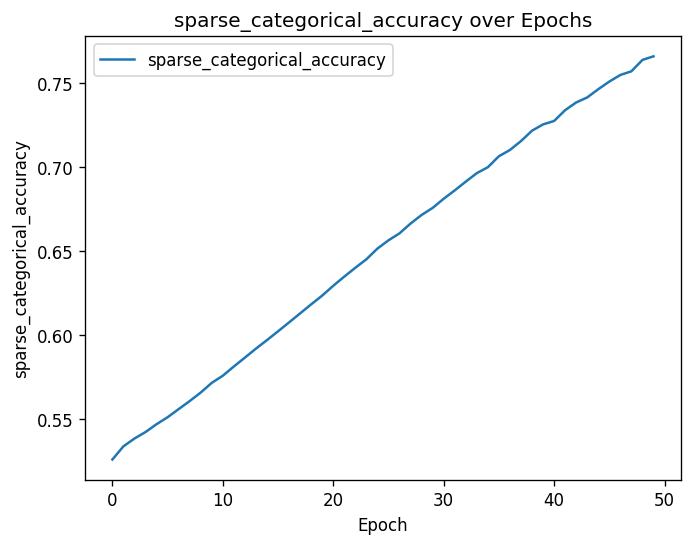

In [23]:
plot_model_metric('sparse_categorical_accuracy')

# Inference After Fine-tuning:

In [24]:
display(Markdown(generate_inference(prompt = "How to spend a nice sunny Sunday morning?")))

<center><font color='Yellow' size='6'>Gemma 3 Output:</font></center>

**<font color='red' size='4'>Instruction:</font>** 
How to spend a nice sunny Sunday morning? 

**<font color='green' size='4'>Response:</font>** 
1. Spend some quality time with your family and friends.
2. Take a nap.
3. Go for a walk.
4. Visit a nearby park.
5. Visit a museum.
6. Visit a historical place.
7. Visit a religious place.
7. Visit a zoo.
8. Visit a botanical garden.
9. Visit a science centre.
10. Visit a library.
1. 3. Visit a park.

In [25]:
display(Markdown(generate_inference(prompt = "Explain the transformer architecture in NLP in a way such that it's easy to understand.")))

<center><font color='Yellow' size='6'>Gemma 3 Output:</font></center>

**<font color='red' size='4'>Instruction:</font>** 
Explain the transformer architecture in NLP in a way such that it's easy to understand. 

**<font color='green' size='4'>Response:</font>** 
The transformer is a type of neural network architecture that has revolutionized the pre-training of language models like BERT and GPT-2. It is also a key component of many downstream tasks like classification, reasoning, and summarization. To explain this architecture in terms that are easy to understand, consider the following high-level steps for how a transformer works: 
1. Pre-training: This involves fine-tuning a pre-trained language model on a corpus of text to pre-train it on the task. This is typically done using a pre-defined dataset or pre-trained checkpoint.
2. Multi-head self-attentive layer: 
- This layer takes as input a single sequence and generates multiple attention layers, each with a different perspective. This allows the model to capture information from different parts of the sequence, leading to better performance. 
3. Final dense layer: 
- This layer takes all the attention layers and concatenates them together as a single 1D layer. This layer takes as input all the attention layers and concatenates them as a single 1D layer. This layer

In [26]:
display(Markdown(generate_inference(prompt = "Explain the general theory of relativity to a 10 years old.")))

<center><font color='Yellow' size='6'>Gemma 3 Output:</font></center>

**<font color='red' size='4'>Instruction:</font>** 
Explain the general theory of relativity to a 10 years old. 

**<font color='green' size='4'>Response:</font>** 
The Earth is a huge ball. The sun is far away from the Earth. The Moon is a thin plane. The Moon makes a circle. The Earth rotates. The Moon moves. The Moon changes. The gravity is strong. The gravity is weak. 

You can build a toy car. You can drive it with a remote control. You can control the speed of the toy car. The toy car will move. The toy car will stop. The toy car will roll. The toy car will turn. The Earth will float. The Moon is a big sphere. The Moon is a big ball. The sun is a small sphere. The sun is far away from the Moon. The Moon is a plane. The Moon makes a circle. The Moon moves. The Earth rotates. The toy car is made of plastic. Plastic is a good material.